# 시뮬레이션 방법론 과제 1 

20249433 최재필 

In [65]:
import QuantLib as ql

import numpy as np
import scipy.stats as sst

import matplotlib.pyplot as plt


## 1. 베리어옵션 가격 계산

- A. 
    - Up vs Down
    - Out vs In
    - Call vs Put (총 2 * 2 * 2 = 8가지)
- B. 
    - 기초자산은 1개
    - 옵션 평가일의 기초자산 가격 S
    - GBM 프로세스 따름 
- C. 
    - 옵션 만기 T (year)
    - 만기까지 knock 여부 관측시점은 m번 ($ \Delta t = T / m $)
- D.
    - 옵션 베리어 B
    - 행사가격 K
    - 무위험 금리 (연속금리) r
    - 변동성 $ \sigma $
    - 배당 = 0
- E. 
    - replication 회수 n번

In [8]:
# Validate input

def check_option_types(barrier_type, option_type):

    barrier_type = barrier_type.lower()
    option_type = option_type.lower()

    assert barrier_type in ['upout', 'downout', 'upin', 'downin']
    assert option_type in ['call', 'put']

    return barrier_type, option_type

In [52]:
# Quantlib을 활용한 analytical solution (mcs와 비교용)

def barrier_option_QL(
        S, r, vol, T, K, B, rebate=0,
        barrier_type='upout',
        option_type='call'
        ):
    
    barrier_type, option_type = check_option_types(barrier_type, option_type)

    # Requires Python >= 3.10 for match-case syntax
    match barrier_type:
        case 'upout':
            barrier_type = ql.Barrier.UpOut
        case 'downout':
            barrier_type = ql.Barrier.DownOut
        case 'upin':
            barrier_type = ql.Barrier.UpIn
        case 'downin':
            barrier_type = ql.Barrier.DownIn
    
    match option_type:
        case 'call':
            option_type = ql.Option.Call
        case 'put':
            option_type = ql.Option.Put
    
    today = ql.Date.todaysDate()
    maturity = today + ql.Period(int(T*365), ql.Days)

    # barrier option
    payoff = ql.PlainVanillaPayoff(option_type, K)
    eu_exercise = ql.EuropeanExercise(maturity)
    barrier_option = ql.BarrierOption(barrier_type, B, rebate, payoff, eu_exercise)

    # market
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(S))
    flat_rate_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), vol, ql.Actual365Fixed()))
    bsm_process = ql.BlackScholesProcess(spot_handle, flat_rate_ts, flat_vol_ts)
    analytic_engine = ql.AnalyticBarrierEngine(bsm_process)

    # pricing
    barrier_option.setPricingEngine(analytic_engine)

    return barrier_option.NPV()

In [61]:
# MCS

def barrier_option_MCS(
        S, r, vol, T, K, B, rebate=0,
        m=100, n=1000,
        barrier_type='upout',
        option_type='call',
        seed=42,
        ):
    
    barrier_type, option_type = check_option_types(barrier_type, option_type)

    np.random.seed(seed)

    ## Calculate price path

    dt = T / m # time step

    Z = np.random.randn(n, m) # n x m matrix of standard normal random variables

    drift = (r - 0.5 * vol**2) * dt
    diffusion = vol * np.sqrt(dt) * Z # n x m

    log_returns = drift + diffusion
    cum_log_returns = np.cumsum(log_returns, axis=1)

    S_t = S * np.exp(cum_log_returns)

    ## Calculate payoff

    is_call = 1 if option_type == 'call' else 0
    is_up = 1 if 'up' in barrier_type else 0
    is_in = 1 if 'in' in barrier_type else 0

    if is_up:
        barrier_breached = np.any(S_t >= B, axis=1)
    else: # down
        barrier_breached = np.any(S_t <= B, axis=1)
    
    if is_in:
        # Knock in 
        payoffs = np.where(
            barrier_breached,
            np.maximum(is_call * (S_t[:, -1] - K), 0),
            rebate
        )

    else: # out
        # Knock out
        payoffs = np.where(
            barrier_breached,
            rebate,
            np.maximum(is_call * (S_t[:, -1] - K), 0),
        )

    discounted_payoffs = np.exp(-r * T) * payoffs

    option_price = np.mean(discounted_payoffs)

    return option_price    

In [62]:
# Market Info
S = 100
r = 0.03
vol = 0.2

# Product Spec.
T = 1 # year
K = 100
B = 120

rebate = 0 # not needed

q = 0 # dividend yield, not needed
r = r - q

barrier_type = 'upout'
option_type = 'call'

# monte carlo simulation
m = 1000
n = 10000

In [63]:
# Compare

ql_price = barrier_option_QL(S, r, vol, T, K, B, rebate, barrier_type, option_type)
mcs_price = barrier_option_MCS(S, r, vol, T, K, B, rebate, m, n, barrier_type, option_type)

ql_price, mcs_price

(1.155369999815115, 1.211769817464179)

## 2. In-Out Parity


### In-Out Parity란

$$ 

call_{knock-in} + call_{knock-out} = call

$$ 

배리어를 나가던 말던 up-and-out(knock-out) 또는 up-and-in(knock-in) 둘 중 하나는 activate 되므로 둘을 합친 것은 항상 vanilla call이 되어야 한다는 parity. 

즉, 0 + c = c 또는 c + 0 = 0 이기에 성립한다는 것. 

출처: [Python for Finance](https://subscription.packtpub.com/book/data/9781783284375/11/ch11lvl1sec176/barrier-in-and-out-parity)


### MCS 옵션 평가에서 활용할 수 있는 방법

둘은 parity이므로 

- 우선 계산량이 적은 vanilla call의 가치를 먼저 mcs로 구하고 
- up-and-out 또는 up-and-in 둘 중 하나를 mcs로 구하면 
- 나머지 하나는 자동으로 구할 수 있어서 

up-and-out이랑 up-and-in 둘 모두의 가치를 구해야 할 때 계산을 덜할 수 있을 것 같다. 

심지어 생각해보니까 먼저 vanilla call 구할 때 price path는 만들어놓으니까 그 다음에 knock-in/out을 계산하면 되는거라서 vanilla 구하는건 어차피 knock-in/out 구하려면 필요한 것인 듯 하다. 

## 3. m, n과 bias, variance의 관계

m, n 변경시 bias, variance의 변화를 시뮬레이션 결과로 설명

- bias:
    - analytic solution의 실제 값과 simulation 결과 (의 평균) 사이의 차이
    - m을 늘려야 discretization error를 줄여 bias를 줄일 수 있다. 
    - 하지만 계속 늘리면 computation cost도 올라가고, 수업시간에도 무조건 늘리는게 좋지는 않다고 배움
- variance: 
    - simulation 결과들 사이의 차이
    - n을 늘려야 simulation들의 std를 줄여 variance를 줄일 수 있다. 
    - 늘릴수록 computation cost 올라감. 

--> variance가 이게 맞나? gpt한테 물어보니 `n_values`(예를 들어 10000번)는 monte carlo simulation 1번 할 때 생성하는 path의 갯수고 `n_simulations`(예를들어 30번), 즉 10000번짜리 simulation을 또 30번 돌려줘야 variance를 알 수 있다는데.

결론: 
- 한정된 연산 자원 내에서 m과 n 사이에 적절하게 분배를 해야한다. 

--> how? 

In [67]:
reference_price = ql_price

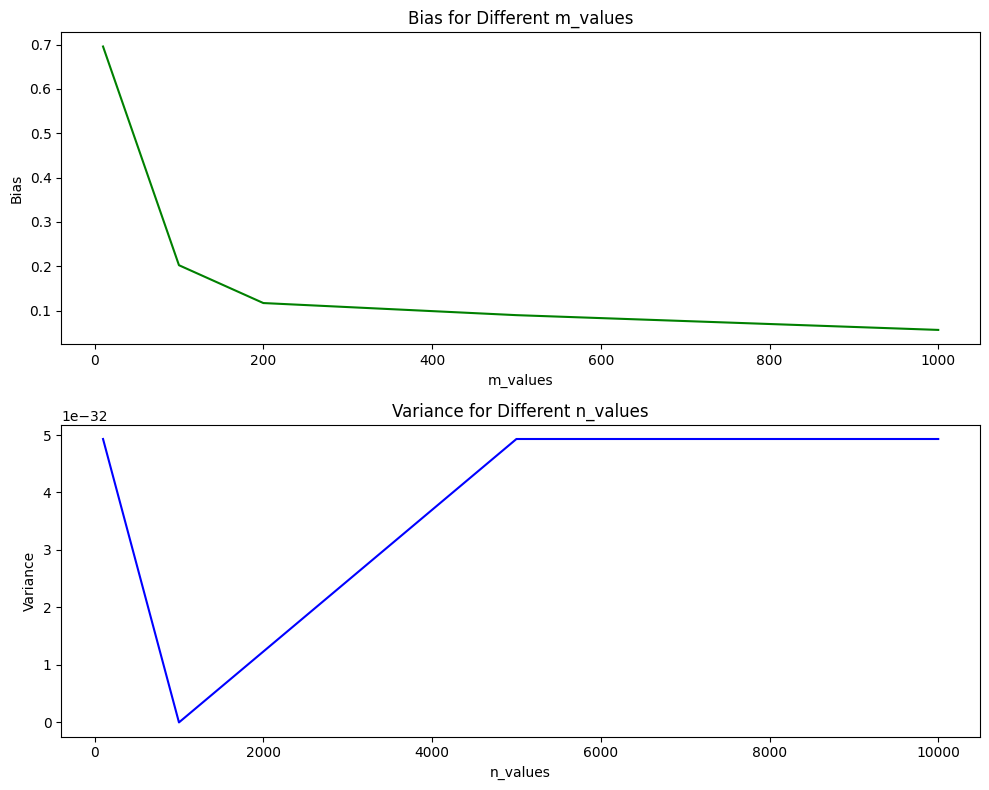

In [69]:
m_values = [10, 100, 200, 500, 1000]
n_values = [100, 1000, 5000, 10000]
num_simulations = 30


bias_results = []
variance_results = []
bias_results = []
variance_results = []

for m in m_values:
    prices = [barrier_option_MCS(S, r, vol, T, K, B, rebate, m, 10000, barrier_type, option_type) for _ in range(num_simulations)]
    mean_price = np.mean(prices)
    bias = mean_price - reference_price
    variance = np.var(prices)
    bias_results.append((m, bias))
    variance_results.append((m, variance))

for n in n_values:
    prices = [barrier_option_MCS(S, r, vol, T, K, B, rebate, 1000, n, barrier_type, option_type) for _ in range(num_simulations)]
    mean_price = np.mean(prices)
    bias = mean_price - reference_price
    variance = np.var(prices)
    bias_results.append((n, bias))
    variance_results.append((n, variance))

# Separate plots for bias and variance
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot bias
ax1.plot(m_values, [result[1] for result in bias_results[:len(m_values)]], 'g-')
ax1.set_xlabel('m_values')
ax1.set_ylabel('Bias')
ax1.set_title('Bias for Different m_values')

# Plot variance
ax2.plot(n_values, [result[1] for result in variance_results[len(m_values):]], 'b-')
ax2.set_xlabel('n_values')
ax2.set_ylabel('Variance')
ax2.set_title('Variance for Different n_values')

plt.tight_layout()
plt.show()